MSE: 183.0346161680706
R2 : 0.1856352643990018
Modèle sauvegardé -> modele_regressor.joblib
Règles exportées -> regles_arbre.txt
Image de l'arbre -> arbre_regressor.png


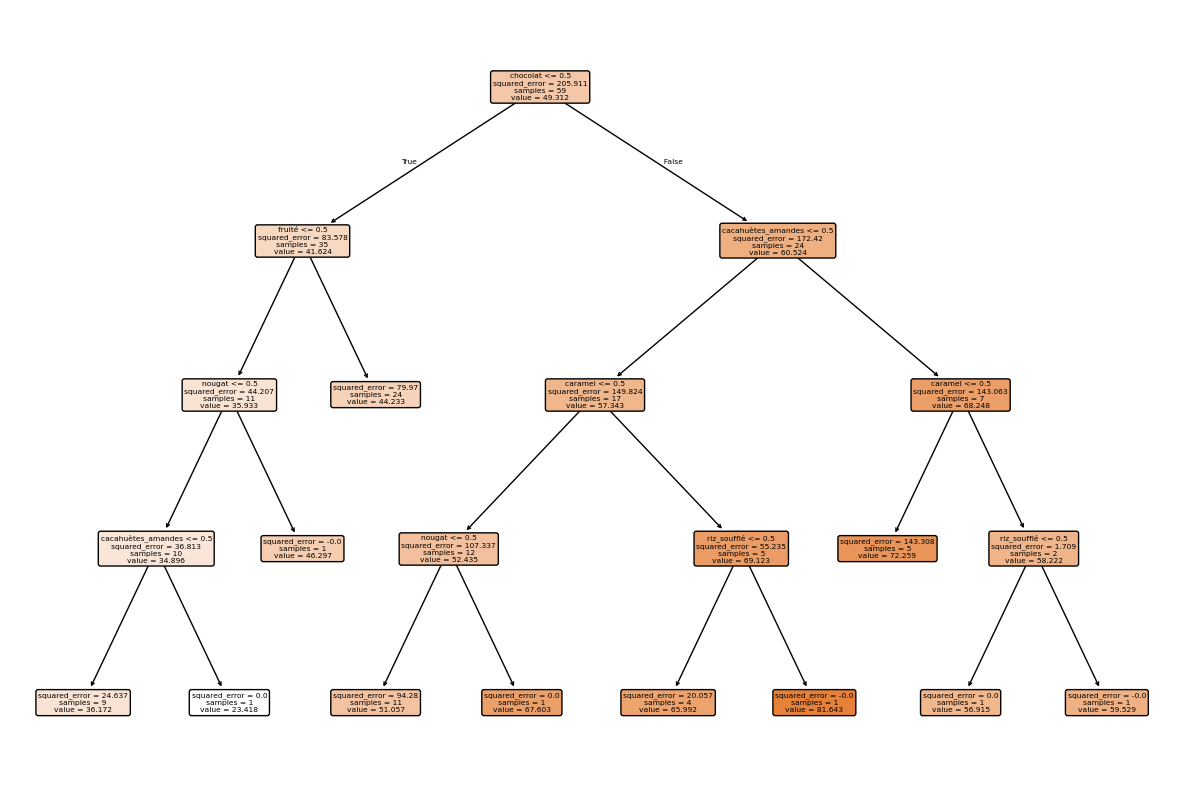

In [5]:
# train_regressor.py
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, export_text, plot_tree
from sklearn.metrics import mean_squared_error, r2_score
import joblib
import matplotlib.pyplot as plt

CSV = "candy-data.csv"
RANDOM_STATE = 42

# 1) Chargement + nettoyage (même logique que test.py)
df = pd.read_csv(CSV)
cols_to_drop = ['competitorname', 'pricepercent', 'sugarpercent', 'pluribus', 'bar', 'hard']
cols_to_drop = [c for c in cols_to_drop if c in df.columns]
df = df.drop(columns=cols_to_drop)

df = df.rename(columns={
    "chocolate": "chocolat",
    "fruity": "fruité",
    "caramel": "caramel",
    "peanutyalmondy": "cacahuètes_amandes",
    "nougat": "nougat",
    "crispedricewafer": "riz_soufflé",
    "winpercent": "popularité"
})

# 2) Features / target
X = df.drop(columns=["popularité"])
y = df["popularité"]

# 3) Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)

# 4) Entraînement (arbre simple)
model = DecisionTreeRegressor(max_depth=4, random_state=RANDOM_STATE)
model.fit(X_train, y_train)

# 5) Évaluation
y_pred = model.predict(X_test)
print("MSE:", mean_squared_error(y_test, y_pred))
print("R2 :", r2_score(y_test, y_pred))

# 6) Sauvegarde
joblib.dump(model, "modele_regressor.joblib")
print("Modèle sauvegardé -> modele_regressor.joblib")

# 7) Export règles texte
try:
    rules = export_text(model, feature_names=list(X.columns))
    with open("regles_arbre.txt", "w", encoding="utf-8") as f:
        f.write(rules)
    print("Règles exportées -> regles_arbre.txt")
except Exception as e:
    print("Export règles impossible:", e)

# 8) Fonction de prédiction "diagnostic" (exemple d'usage)
def diagnostiquer_dict(feature_dict):
    """feature_dict : dict {col_name: value, ...}"""
    row = pd.DataFrame([feature_dict])
    # tentative de conversion automatique des types
    for c in row.columns:
        try:
            row[c] = pd.to_numeric(row[c])
        except:
            pass
    return float(model.predict(row)[0])

# 9) Visualiser l'arbre
plt.figure(figsize=(12,8))
plot_tree(model, feature_names=X.columns, filled=True, rounded=True)
plt.tight_layout()
plt.savefig("arbre_regressor.png", dpi=150)
print("Image de l'arbre -> arbre_regressor.png")
